In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import math
# from better_profanity import profanity

# Nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\14793\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\14793\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# borrowed from stackoverflow https://stackoverflow.com/a/49146722
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def remove_unwanted(document):

    # remove URLS 
    document = re.sub(r'http\S+', ' ', document)
    # remove emoji's
    document = remove_emoji(document)
    # remove punctuation
    document = re.sub("[^0-9A-Za-z ]", "" , document)
    # remove double spaces
    document = document.replace('  ',"")
    
    return document.strip()

In [4]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [5]:
def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)    
    Di, Dij = col_i.sum(), col_ij.sum()    
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

In [6]:
# def lemmatizing(text):
#     sent_tokenized = text.split(" ")
#     lemmatizer = WordNetLemmatizer()
#     words = [lemmatizer.lemmatize(word) for word in sent_tokenized]
#     tweet = " ".join([w for w in words])
#     return tweet

In [7]:
data = pd.read_csv("Harvey_stressor.csv")

exclusive_emotion = ["approval","desire","admiration","love","gratitude","excitement","optimism","joy","amusement","neutral"]
extracted_data = data.loc[~data["Emotion"].isin(exclusive_emotion)].reset_index()
text_corpus = extracted_data["Tweet"].astype(str)
len(text_corpus)

98229

### This section is for expansion purpose

In [8]:
# climate_data = []
# vocab = ["climate","warming","global","change","carbon","pollution","greenhouse","energy","fossil","fuel","hoax"]
# words_re = re.compile("|".join(vocab))

# for tweet in text_corpus:
#     if words_re.search(tweet):
#         climate_data.append(tweet)

# len(climate_data)

In [10]:
new_corpus = []

for text in text_corpus:

    clean_text = remove_unwanted(str(text))
    clean_text = ' '.join([w for w in clean_text.split() if len(w)>1])
    # clean_text = lemmatization(clean_text)
    # clean_text = profanity.censor(clean_text, "")
    
    new_corpus.append(clean_text)

# new_corpus = np.array(new_corpus)

In [ ]:
# clean_tweet_data = np.array(new_corpus)
# extracted_data["Tweet"] = clean_tweet_data
# extracted_data.to_csv('Harvey_stressor.csv',index=False)

In [11]:
stop_words = stopwords.words('english')
extended_words = ["hurricaneharvey","hurricane","harvey","texas","austin","galveston","storm","winds","houston","david","usa","twitter","donald",
                  "trump","trumps","san","hey","houstons","southeast","tomorrow","else","potus"," harveys","texans","via","wind"]
stop_words.extend(extended_words)

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize,
                        max_features=  300,
                        encoding='utf-8')

train_data = tfidf.fit_transform(new_corpus)


c:\Users\14793\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\14793\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['harveys'] not in stop_words.
  warnings.warn(


In [13]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names_out()
top_n = 50
top_features = [features[i] for i in indices[:top_n]]
print (top_features)

['evacuation', 'doings', 'okay', 'lost', 'sound', 'space', 'nothing', 'seriously', 'wont', 'damaging', 'something', 'every', 'mean', 'tell', 'toward', 'dead', 'face', 'closed', 'chaser', 'red', 'waiting', 'soon', 'along', 'believe', 'never', 'lord', 'everything', 'die', 'dealing', 'sustained', 'fake', 'response', 'sorry', 'bracing', 'everybody', 'place', 'center', 'might', 'part', 'plan', 'deluge', 'lot', 'support', 'looking', 'big', 'wonder', 'long', 'call', 'bless', 'worry']


In [14]:
# Materialize the sparse data
data_dense = train_data.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.126669992229043 %


## SAMPLE LDA

In [ ]:
warnings.filterwarnings('ignore')
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations  
                                      random_state=100,          # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(train_data)

pprint(lda_model)  # Model attributes

LatentDirichletAllocation(n_components=20, n_jobs=-1, random_state=100)


In [ ]:
avg_coherence = get_average_topic_coherence(train_data, lda_model.components_, 10)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(train_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(train_data))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1078640.9136004986
Perplexity:  659.3927392122183
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## GridSearch LDA

In [ ]:
# Define Search Param
topic_number = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
# decay_rate = [0.5, 0.7, 0.9]
coherence_score = []
for i in topic_number:
    lda_model = LatentDirichletAllocation(n_components=i,            # Number of topics
                                        learning_decay= 0.7,
                                        max_iter=10,               # Max learning iterations  
                                        random_state=100,          # Random state
                                        evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                        n_jobs = -1,               # Use all available CPUs
                                        )
    lda_output = lda_model.fit_transform(train_data)
    coherence_score.append(get_average_topic_coherence(train_data, lda_model.components_, 25))
    print("LDA model with "+str(i)+" topics is done!")
        
coherence_score = np.array(coherence_score)

LDA model with 5 topics is done!
LDA model with 10 topics is done!
LDA model with 15 topics is done!
LDA model with 20 topics is done!
LDA model with 25 topics is done!
LDA model with 30 topics is done!
LDA model with 35 topics is done!
LDA model with 40 topics is done!
LDA model with 45 topics is done!
LDA model with 50 topics is done!
LDA model with 55 topics is done!
LDA model with 60 topics is done!
LDA model with 65 topics is done!
LDA model with 70 topics is done!
LDA model with 75 topics is done!
LDA model with 80 topics is done!
LDA model with 85 topics is done!
LDA model with 90 topics is done!
LDA model with 95 topics is done!
LDA model with 100 topics is done!


In [ ]:
plotting_coherence = np.delete(coherence_score,0)
np.savetxt('coherence_score.out', plotting_coherence, delimiter=',')

In [32]:
plotting_coherence = np.loadtxt("coherence_score.out", dtype=float)

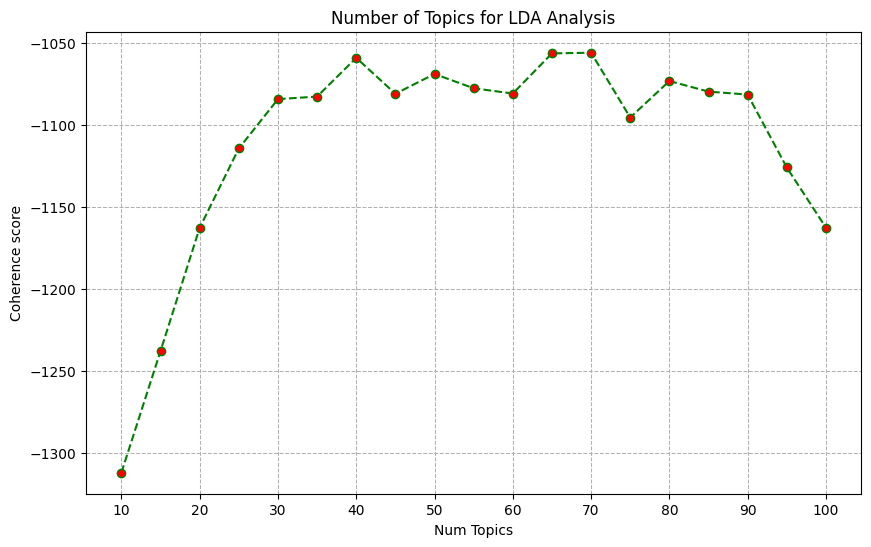

In [33]:
topics_no = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
plt.figure(figsize=(10,6))

plt.plot(topics_no,plotting_coherence, linestyle='--', marker='o', c='green', mfc='red')
plt.title("Number of Topics for LDA Analysis")
plt.xlabel("Num Topics")
plt.xticks([10,20,30,40,50,60,70,80,90,100])

plt.ylabel("Coherence score")
plt.grid(which ='major',linestyle='--', linewidth=0.75)
plt.show()

In [22]:
lda_model = LatentDirichletAllocation(n_components=70,            # Number of topics
                                    learning_decay= 0.7,
                                    max_iter=10,               # Max learning iterations  
                                    random_state=100,          # Random state
                                    evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                    n_jobs = -1,               # Use all available CPUs
                                    )
lda_output = lda_model.fit_transform(train_data)
pprint(lda_model.get_params())

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 70,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [23]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(train_data)

# column names
topicnames = ["Topic" + str(i) for i in range(70)]

# index names
docnames = ["Doc" + str(i) for i in range(len(new_corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'white'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(30).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,Topic50,Topic51,Topic52,Topic53,Topic54,Topic55,Topic56,Topic57,Topic58,Topic59,Topic60,Topic61,Topic62,Topic63,Topic64,Topic65,Topic66,Topic67,Topic68,Topic69,dominant_topic
Doc0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.270000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.330000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,36
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
Doc2,0.010000,0.010000,0.290000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.310000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,62
Doc3,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19
Doc4,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46
Doc5,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.0100

In [24]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,7191
1,10,3586
2,26,3528
3,8,3109
4,59,3034
...,...,...
65,62,668
66,68,623
67,30,603
68,37,520


In [25]:
# Print the topics with their terms
terms = tfidf.get_feature_names_out()
lda_components = lda_model.components_

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['way', 'like', 'name', 'place', 'get', 'people', 'safe', 'dont', 'sound', 'one']
Topic 1:  ['going', 'due', 'closed', 'safe', 'stay', 'get', 'please', 'hit', 'everyone', 'today']
Topic 2:  ['flooding', 'catastrophic', 'expected', 'well', 'cause', 'lifethreatening', 'likely', 'bring', 'hit', 'rain']
Topic 3:  ['doe', 'best', 'shelter', 'wish', 'safe', 'everyone', 'place', 'much', 'path', 'friend']
Topic 4:  ['hope', 'anyone', 'house', 'doesnt', 'safe', 'stay', 'everyone', 'path', 'get', 'hit']
Topic 5:  ['wow', 'making', 'give', 'landfall', 'safe', 'stay', 'everyone', 'people', 'category', 'even']
Topic 6:  ['still', 'today', 'already', 'flooding', 'rain', 'category', 'even', 'leave', 'one', 'could']
Topic 7:  ['away', 'worst', 'case', 'isnt', 'loom', 'everybody', 'scenario', 'people', 'everyone', 'even']
Topic 8:  ['thought', 'prayer', 'affected', 'would', 'people', 'path', 'safe', 'everyone', 'stay', 'go']
Topic 9:  ['day', 'wonder', 'next', 'along', 'coast', 'rain', 'one',

In [26]:
cluster_no = lda_model.n_components

# Construct the k-means clusters
clusters = KMeans(n_clusters=cluster_no, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

c:\Users\14793\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Component's weights: 
 [[ 0.1   0.11  0.17  0.09  0.11  0.07  0.08  0.09  0.23  0.08  0.3   0.1
   0.1   0.11  0.1   0.09  0.11  0.11  0.06  0.12  0.08  0.1   0.12  0.08
   0.11  0.12  0.3   0.11  0.13  0.07  0.06  0.08  0.13  0.16  0.09  0.11
   0.22  0.07  0.08  0.08  0.11  0.09  0.11  0.08  0.12  0.09  0.15  0.1
   0.09  0.1   0.11  0.1   0.09  0.12  0.08  0.08  0.08  0.08  0.08  0.26
   0.08  0.09  0.07  0.12  0.08  0.1   0.1   0.1   0.08  0.07]
 [-0.02 -0.03 -0.07 -0.02 -0.03 -0.02 -0.02 -0.02 -0.1  -0.02  0.93 -0.02
  -0.03 -0.03 -0.03 -0.02 -0.03 -0.03 -0.01 -0.03 -0.02 -0.03 -0.03 -0.02
  -0.03 -0.04 -0.01 -0.03  0.02 -0.02 -0.01 -0.02 -0.03 -0.04 -0.02 -0.03
  -0.13 -0.02 -0.02 -0.02 -0.03 -0.02 -0.03 -0.02 -0.03 -0.03 -0.05 -0.03
  -0.02 -0.03 -0.02 -0.02 -0.02 -0.03 -0.02 -0.02 -0.02 -0.02 -0.02 -0.23
  -0.02 -0.02 -0.02 -0.04 -0.02 -0.02 -0.02 -0.03 -0.02 -0.02]]
Perc of Variance Explained: 
 [0.   0.04]


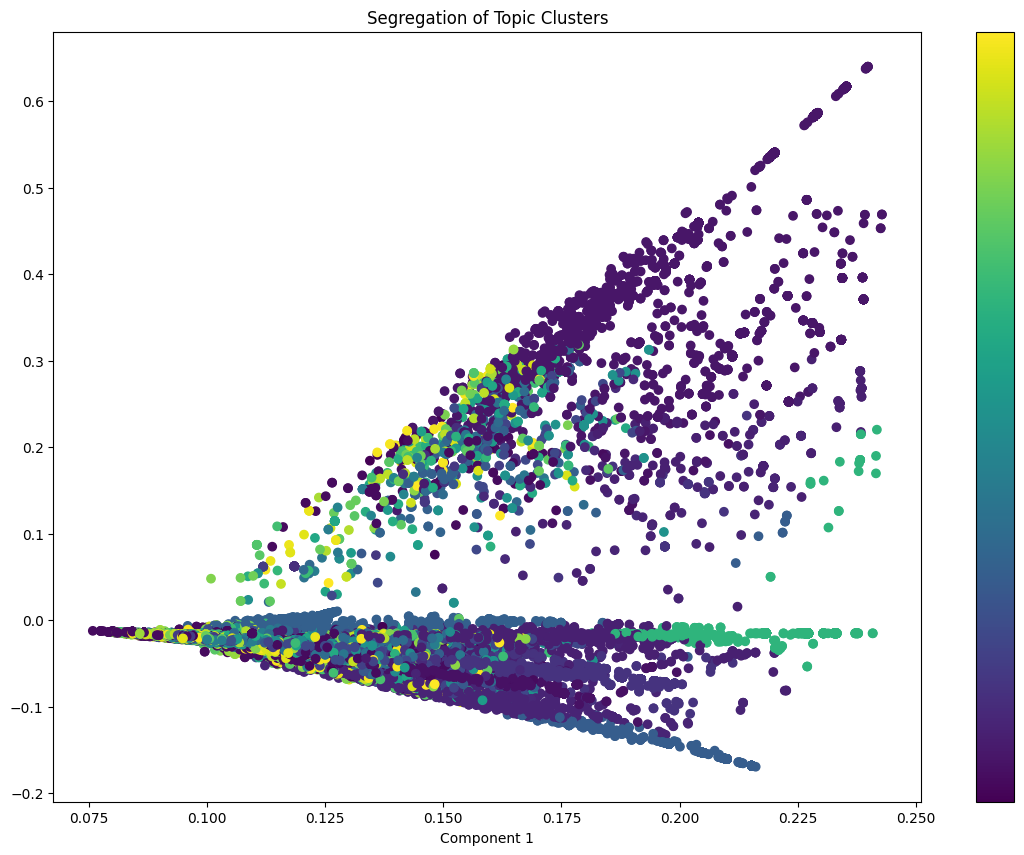

In [27]:
# Plot
plt.figure(figsize=(14, 10))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.colorbar(ticks=[])

In [28]:
import pyLDAvis.lda_model

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model,train_data,tfidf)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.205354 -0.007880       1        1  2.719150
59    -0.139243  0.018279       2        1  2.543031
8     -0.265974  0.010981       3        1  2.492318
10    -0.295150  0.098604       4        1  2.472916
36     0.081110 -0.038793       5        1  2.196101
...         ...       ...     ...      ...       ...
29     0.061872 -0.083611      66        1  0.995699
5     -0.028810  0.026432      67        1  0.985182
37     0.014524  0.124113      68        1  0.954610
30    -0.031725 -0.045752      69        1  0.850199
18     0.117333 -0.167931      70        1  0.771416

[70 rows x 5 columns], topic_info=         Term         Freq        Total Category  logprob  loglift
197   praying  1955.000000  1955.000000  Default  30.0000  30.0000
125        im  1601.000000  1601.000000  Default  29.0000  29.0000
193      pray  1420.000000  1420.000000  Default  28.0000  28.0000
195   prayers  1490.000000  1490.000000  Default  27.0000  27.0000
115      help  1946.000000  1946.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
220       say     0.026613   697.683374  Topic70 -10.7824  -5.3094
101        go     0.026530  1176.987404  Topic70 -10.7855  -5.8355
0          12     0.026530   222.224044  Topic70 -10.7855  -4.1685
1         130     0.026530   317.462611  Topic70 -10.7855  -4.5252
2    affected     0.026530  2063.045598  Topic70 -10.7855  -6.3967

[2535 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        21  0.994492        12
1        11  0.995393       130
2         1  0.176438  affected
2         2  0.107123  affected
2         3  0.237028  affected
...     ...       ...       ...
295      62  0.050414      yall
296      21  0.996806      year
297      60  0.998468       yet
298      48  0.997747     youre
299      25  0.998105   youtube

[1617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 60, 9, 11, 37, 3, 34, 47, 29, 26, 45, 33, 41, 20, 23, 18, 64, 5, 54, 43, 36, 2, 13, 28, 25, 67, 48, 17, 15, 14, 51, 50, 68, 52, 1, 12, 8, 46, 22, 35, 49, 42, 62, 53, 4, 66, 16, 55, 59, 24, 56, 7, 32, 57, 10, 61, 40, 65, 58, 39, 21, 44, 69, 70, 63, 30, 6, 38, 31, 19])

## Auxiliary Testing

In [ ]:
# # Define the number of topics or components
# num_components=10

# # Create LDA object
# model=LatentDirichletAllocation(n_components=num_components)

# # Fit and Transform SVD model on data
# lda_matrix = model.fit_transform(train_data)

# # Get Components 
# lda_components=model.components_

In [ ]:
# Print the topics with their terms
# terms = tfidf.get_feature_names_out()

# for index, component in enumerate(lda_components):
#     zipped = zip(terms, component)
#     top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
#     top_terms_list=list(dict(top_terms_key).keys())
#     print("Topic "+str(index)+": ",top_terms_list)